In [1]:
import pandas as pd

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools as pdt
from rdkit.Chem import GraphDescriptors
from rdkit.Chem import rdFMCS as fmcs

import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.cluster import BisectingKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import ipywidgets

In [2]:
# load dataset
# coagulation factors
from rdkit.Chem import PandasTools as pdt

chembl4530 = None
# coagulation factor xiii
chembl2016 = pdt.LoadSDF('CHEMBL2016_actives.sdf', embedProps=True, molColName=None, smilesName='smiles')
# coagulation factor ix
chembl2820 = None
# coagulation factor xi
chembl2821 = None
# coagulation factor xii
chembl3991 = None
# coagulation factor vii
chembl244 = pdt.LoadSDF('CHEMBL244_actives.sdf', embedProps=True, molColName=None, smilesName='smiles')
# coagulation factor x
chembl204 = pdt.LoadSDF('CHEMBL204_actives.sdf', embedProps=True, molColName=None, smilesName='smiles')
# thrombin

chembl234 = pdt.LoadSDF('CHEMBL234_actives.sdf', embedProps=True, molColName=None, smilesName='smiles')
# dopamine d3 receptor

In [3]:

# drop unnecessary information
print("2016:\n",chembl2016.nunique())

print("244:\n",chembl244.nunique())

print("204:\n",chembl204.nunique())

print("234:\n",chembl234.nunique())
# std_type jest jedyny, nie musimy go uwzględniać
# podobnie target_id target_name target_type organism i ID
# std_unit jest jedyny, nie należy go uwzględniać ani konwertować std_val
dropcols = ['CdId','Mol Weight','Formula','target_id','target_name','organism','target_type','ID','std_unit','std_type']
chembl2016 = chembl2016.drop(dropcols,axis=1)
chembl244 = chembl244.drop(dropcols,axis=1)
chembl204 = chembl204.drop(dropcols,axis=1)
chembl234 = chembl234.drop(dropcols,axis=1)
chembl2016['target'] = 'coagulation factor ix'
chembl244['target'] = 'coagulation factor x'
chembl204['target'] = 'thrombin'
chembl234['target'] = 'dopamine d3 receptor'
data11 = chembl2016
data12 = chembl244
data13 = chembl204

data21 = pd.concat([chembl2016,chembl244]).reset_index(drop=True)
data22 = pd.concat([chembl204,chembl2016]).reset_index(drop=True)
data23 = pd.concat([chembl244,chembl204]).reset_index(drop=True)

data31 = pd.concat([chembl244,chembl204,chembl2016]).reset_index(drop=True)

dataoo = chembl234
dataoj = pd.concat([chembl234,chembl204]).reset_index(drop=True)
datajo = pd.concat([chembl204,chembl234]).reset_index(drop=True)
dataoB = pd.concat([chembl234,chembl244,chembl204]).reset_index(drop=True)

2016:
 CdId             528
Mol Weight       414
Formula          416
cmpd_chemblid    528
std_type           1
std_value        371
std_unit           1
target_id          1
target_name        1
organism           1
target_type        1
ID                 1
smiles           528
dtype: int64
244:
 CdId             4226
Mol Weight       3057
Formula          3074
cmpd_chemblid    4226
std_type            1
std_value        1038
std_unit            1
target_id           1
target_name         1
organism            1
target_type         1
ID                  1
smiles           4225
dtype: int64
204:
 CdId             3158
Mol Weight       2379
Formula          2383
cmpd_chemblid    3158
std_type            1
std_value        1110
std_unit            1
target_id           1
target_name         1
organism            1
target_type         1
ID                  1
smiles           3156
dtype: int64
234:
 CdId             3833
Mol Weight       2503
Formula          2501
cmpd_chemblid    3833
std

In [4]:
# przygotowanie danych poprzez skalowanie
# jeżeli dane mają dystrybucję normalną
def gaussianScaler(numArr):
    # standard gaussian scaler
    # X' = (X-mu)/sigma
    mean = numArr.mean()
    std = numArr.std()
    numArr = (numArr - mean) / std
    return numArr

# jeżeli dane podążają za 'power law' (~e^x)
def logScaler(numArr):
    # standard logarythmic scaler
    numArr = np.log(numArr)
    return numArr

# jeżeli dystrybucja jest niejasna
# dane dzielimy na kwantyle
def createQuantiles(dfColumn, numQuantiles):
    # create as many quantiles as wanted
    return pd.qcut(dfColumn, numQuantiles, labels=False, duplicates='drop')

# i normalizujemy minmaxem
def minMaxScaler(numArr):
    # standard minmax scaler
    minx = np.min(numArr)
    maxx = np.max(numArr)
    # linearly map all values from minimal to maximal
    # to values ranging from 0 to 1
    numArr = (numArr - minx) / (maxx - minx)
    return numArr

class Featurizer:
    def __init__(self, smiles_col='smiles', activity_col='std_value', **kwargs):
        self.smiles_col = smiles_col
        self.activity_col = activity_col
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()

class ClusteringFeaturizer(Featurizer):
    def __init__(self, activity_dist='gaussian', qcount=0, radius=2, length=1024, **kwargs):
        self.activity_dist = activity_dist
        self.qcount = qcount
        self.radius = radius
        self.length = length
        super().__init__(**kwargs)
    
    def __call__(self, df,quick=False):
        ## check if valid arguments
        # check activity distribution
        if(self.activity_dist != 'gaussian' and self.activity_dist != 'powerlaw' and self.activity_dist != 'quantiles'):
            print('wrongly set attribute activity_dist. Please use one of the following:\ngaussian, powerlaw, quantiles')
            return pd.DataFrame()
        # if quantiles are selected, there must be at least two of them
        if(self.activity_dist == 'quantiles' and self.qcount < 2):
            print('wrongly set quantile count.')
            return pd.DataFrame()
        # reconvert everything to float in order to prepare for scaling
        df[self.activity_col] = df[self.activity_col].astype(float)
        # generate column names for features in morgan fingerprints
        c = ['activity']+['f_'+str(n) for n in np.arange(self.length)]
        ## quick will eat more memory
        if quick:
            features = []
        else:
            features = pd.DataFrame(columns=c)
        ## prepare activity by scaling the data with scaler
        # chosen to the selected distribution
        match self.activity_dist:
            case 'gaussian':
                df[self.activity_col] = gaussianSacler(df[self.activity_col])
            case 'powerlaw':
                df[self.activity_col] = logScaler(df[self.activity_col])
            case 'quantiles':
                df[self.activity_col] = createQuantiles(df[self.activity_col], self.qcount)
                df[self.activity_col] = minMaxScaler(df[self.activity_col])
            case _:
                #do nothing
                return
        ## generate features
        for i, row in df.iterrows():
            smiles = row[self.smiles_col]
            activity = row[self.activity_col]
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length)
            # vector containing morgan fingerprints
            fpvector = np.array(fp,dtype=int)
            # vector representing the molecule, contains
            # fingerprints and activity in floats
            vec = np.array([np.hstack(([activity],fpvector))],dtype=float)
            if quick:
                features.append(vec)
            else:
                fta = pd.DataFrame(vec,columns=c)
                features = pd.concat([features,fta],ignore_index=True)
        return features

In [5]:
datas = [data11,data12,data13,data21,data22,data23,data31,dataoo,dataoj,dataoB,datajo]
datasq = [dataoo,dataoB,datajo,data13]
datasuber = [dataoB]

feature_count = 1024
quantile_count = 100
featurizer = ClusteringFeaturizer(activity_dist='quantiles',qcount=quantile_count,length=feature_count)
feature_count = (feature_count + 1) * 1.0 # + activity ; konwersja na float
datas = list(map(lambda x: featurizer(x),datasuber))

/tmp/ipykernel_45100/3449602723.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features = pd.concat([features,fta],ignore_index=True)


In [ ]:
#clcard = []
clserrm = []
clserrd = []
clserrmb = []
clserrdb = []
rr = 50
print("running cluster cardinality: ")
for dddd in datas:
    print("running analysis for next data.")
    dclserrm = []
    dclserrd = []
    dclserrmb = []
    dclserrdb = []
    for i in range(4,rr,2):
        res = []
        resb = []
        print(i,end=",")
        for _ in range(5):
            cl = BisectingKMeans(n_clusters=i)
            clds = cl.fit_transform(dddd)
            clid = cl.labels_
            res.append(silhouette_score(dddd, cl.labels_))
            resb.append(np.sum(clds[np.arange(clds.shape[0]),clid]))
        dclserrm.append(np.mean(res))
        dclserrd.append(np.std(res))
        
        dclserrmb.append(np.mean(resb))
        dclserrdb.append(np.std(resb))
    clserrm.append(dclserrm)
    clserrd.append(dclserrd)
    clserrmb.append(dclserrmb)
    clserrdb.append(dclserrdb)
print("done")

In [ ]:
plt.figure(figsize=(8,8))
for datapoint in range(len(clserrm)):
    plt.errorbar(range(4,rr,2), clserrm[datapoint],clserrd[datapoint],linestyle='None',fmt='o')


plt.title('Score vs Clusters Used')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.legend(list(map(len,datas)))

In [ ]:
plt.figure(figsize=(8,8))
for datapoint in range(len(clserrm)):
    x = np.array(clserrmb[datapoint]) / len(datas[datapoint])
    y = np.array(clserrdb[datapoint]) / len(datas[datapoint])
    plt.errorbar(range(4,rr,2), x,y,linestyle='None',fmt='^')

plt.title('Total Distance normalized vs Clusters Used')
plt.xlabel('Number of clusters')
plt.ylabel('Distance normalized')
plt.legend(list(map(len,datas)))

In [ ]:
data11.to_csv("data11.csv")
data12.to_csv("data12.csv")
data13.to_csv("data13.csv")
data21.to_csv("data21.csv")
data22.to_csv("data22.csv")
data23.to_csv("data23.csv")
data31.to_csv("data31.csv")
dataoo.to_csv("dataoo.csv")
dataoj.to_csv("dataoj.csv")
dataoB.to_csv("dataoB.csv")
pd.DataFrame(clserrmb).to_csv("clserrmb.csv")
pd.DataFrame(clserrdb).to_csv("clserrdb.csv")
pd.DataFrame(clserrm).to_csv("clserrm.csv")
pd.DataFrame(clserrd).to_csv("clserrd.csv")

In [13]:
def cluster(dataset,n):
    clustering = BisectingKMeans(n_clusters=n)
    clusterdist = clustering.fit_transform(dataset)
    clusterid = clustering.labels_
    clusterdist = clusterdist[np.arange(len(dataset)),clusterid]
    processed_data = dataset.copy()
    processed_data['centroid'] = clusterid
    processed_data['distance'] = clusterdist
    pca = PCA(n_components=3)
    pcdata3d = pd.DataFrame(pca.fit_transform(processed_data.drop(["centroid","distance"], axis=1)))
    pcdata3d.columns = ["pc1", "pc2", "pc3"]

    sizes = np.power(10,6)/np.power(processed_data["distance"],7)
    fig = plt.figure(figsize=(11,9))
    ax = fig.add_subplot(projection='3d')
    ax.azim = 35
    ax.elev = 35
    sc = ax.scatter(pcdata3d["pc1"],pcdata3d["pc2"],pcdata3d["pc3"],cmap=plt.cm.gist_rainbow,c=processed_data["centroid"],s=sizes)
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()
    return clustering, processed_data, pcdata3d

def showcluster(cid,dat,pcdat):
    cdata = dat[dat["centroid"]==cid]['distance']
    pickcluster = pcdat.loc[dat["centroid"]==cid]
    sizes = np.power(10,6)/np.power(cdata,7)
    print(sizes.shape)
    print(pickcluster.shape)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.azim = 35
    ax.elev = 35
    sc = ax.scatter(pickcluster["pc1"],pickcluster["pc2"],pickcluster["pc3"],cmap=plt.cm.viridis,s=sizes)
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)


In [14]:
def getAtoms(df):
    mols = []
    for row in df:
        smiles = row
        mol = Chem.MolFromSmiles(smiles)
        mols.append(mol)
    return mols

def findmcs(cid,dat,ogdat):
    centroid = dat.loc[dat['centroid'] == cid, :]
    smilesss = ogdat.loc[dat['centroid']==cid, :]
    act = smilesss['std_value']
    dst = centroid['distance']
    mol = smilesss['smiles'][:10]
    if (mol.empty or mol.size < 2):
        print("cluster did not converge close enough")
        #plt.scatter(dst,act)
        #plt.show()
    else:
        mol = mol.reset_index(drop=True)
        #print(mol)
        mcs = Chem.MolFromSmarts(fmcs.FindMCS(getAtoms(mol),timeout=1).smartsString)
        #plt.scatter(dst,act)
        #plt.show()
        img = Chem.Draw.MolToImage(mcs)
        return img

In [15]:
from ipywidgets import interact

def show_molecule(smiles=''):
    if not smiles:
        return
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    if not mol:
        return
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    mblock = Chem.MolToMolBlock(mol, kekulize=False)

    # 3D VIEW:
    #view = py3Dmol.view(width=800, height=500)
    #view.addModel(Chem.MolToMolBlock(mol, kekulize=True), 'mol')
    #view.setStyle({'model': -1}, {"stick": {'color': 'white', 'radius': 0.15}, "sphere": {'radius': .4}})
    #view.zoomTo({'model': -1})
    #view.show()


def examine_cluster(dat,dat_sorted,cid,eid):    
    centroid = dat_sorted.loc[dat['centroid'] == cid, :]
    print(eid,"/",len(centroid))
    print(centroid['distance'].iloc[eid])
    mol = centroid['smiles']
    #mol = mol.reset_index()
    print(centroid['target'].iloc[eid])
    show_molecule(mol.iloc[eid])

In [16]:
def centroidanalysis(dat,ccount):
    dsts = []
    count = []
    for i in range(ccount):
        centroid = dat[dat['centroid']==i]
        dsts.append(np.sum(centroid['distance']))
        count.append(len(centroid))
    plt.scatter(count,dsts)
    plt.title("centroid count vs total distance")
    plt.xlabel("count")
    plt.ylabel("distance")
    plt.show()

def cal_centroidanalysis(dat,ccount):
    dsts = []
    count = []
    for i in range(ccount):
        centroid = dat[dat['centroid']==i]
        dsts.append(np.sum(centroid['distance']))
        count.append(len(centroid))
    return dsts, count

In [17]:
def ccount(dat,cs):
    count = []
    for i in range(cs):
        centroid = dat[dat['centroid']==i]
        count.append(len(centroid))
    plt.bar(range(cs),count)
    plt.title("centroid count")
    plt.xlabel("centroid")
    plt.ylabel("amount")
    plt.show()

def cal_ccount(dat,cs):
    count = []
    for i in range(cs):
        centroid = dat[dat['centroid']==i]
        count.append(len(centroid))
    return count

In [18]:
def perform_analysis(dat,n,og,adj=None,ogadj=None):
    cl, processed, pcadata = cluster(dat,n)
    ccount(processed,n)
    centroidanalysis(processed,n)
    dat_sorted = processed.copy()
    dat_sorted['smiles'] = og['smiles']
    dat_sorted['target'] = og['target']
    dat_sorted = dat_sorted.sort_values(by=['distance'])
    adjoint = adj.copy()
    nl = cl.predict(adjoint)
    nd = cl.transform(adjoint)[np.arange(len(adjoint)),nl]
    adjoint['centroid'] = nl
    adjoint['distance'] = nd
    prevd, prevc = cal_centroidanalysis(processed,n)
    newd, newc = cal_centroidanalysis(adjoint,n)
    plt.scatter(newd,newc,c='red',marker='^')
    plt.scatter(prevd,prevc,c='blue',marker='o')
    plt.title("centroid count")
    plt.xlabel("centroid")
    plt.ylabel("amount")
    plt.show()
    plt.bar(range(n),newc,color='red')
    plt.bar(range(n),prevc,color='blue')
    plt.title("centroid count")
    plt.xlabel("centroid")
    plt.ylabel("amount")
    plt.show()
    adj_sorted = adjoint.copy()
    adj_sorted['target'] = ogadj['target']
    adj_sorted['smiles'] = ogadj['smiles']
    adj_sorted = adj_sorted.sort_values(by=['distance'])
    return dat_sorted, adj_sorted, processed, adjoint

In [19]:
def cal_labelc(dat,cc):
    labelsa = []
    labelsb = []
    for i in range(cc):
        centroid = dat[dat['centroid']==i]
        c = len(centroid[centroid['target']=='dopamine d3 receptor'])
        labelsb.append(c)
        labelsa.append(len(centroid)-c)
    return labelsa, labelsb

def show_labelc(dat,cc,ogdat):
    dat = dat.copy()
    dat['target'] = ogdat['target']
    coa, dop = cal_labelc(dat,cc)
    plt.scatter(range(cc),coa,c='blue',marker='^',label="other")
    plt.scatter(range(cc),dop,c='red',marker='o',label="dopamine")
    plt.legend()
    plt.show()

In [ ]:
a1, a2, a3, a4 = perform_analysis(datas[3],30,data21,datas[6],data31)

In [ ]:
@interact(cid=(0,30))
def f1(cid=6):
    return findmcs(cid,a3,data21)
@interact(cid=(0,30))
def f2(cid=6):
    return findmcs(cid,a4,data31)
@interact(cid=(0,30),eid=(0,100))
def f3(cid=6,eid=0):
    return examine_cluster(a3,a1,cid,eid)
@interact(cid=(0,30),eid=(0,100))
def f3(cid=6,eid=0):
    return examine_cluster(a4,a2,cid,eid)

In [ ]:
for i in range(20,40):
    examine_cluster(a4,a2,18,i)

In [ ]:
b1, b2, b3, b4 = perform_analysis(datas[0],10,data11,datas[6],data31)

In [ ]:
@interact(cid=(0,30))
def f1(cid=6):
    return findmcs(cid,b1,data11)
@interact(cid=(0,30))
def f2(cid=6):
    return findmcs(cid,b2,data31)
@interact(cid=(0,30),eid=(0,100))
def f3(cid=6,eid=0):
    return examine_cluster(b3,b1,cid,eid)
@interact(cid=(0,30),eid=(0,100))
def f3(cid=6,eid=0):
    return examine_cluster(b4,b2,cid,eid)

In [ ]:
for i in range(21):
    examine_cluster(b4,b2,9,i)

In [ ]:
c1, c2, c3, c4 = perform_analysis(datas[7],30,dataoo,datas[8],dataoj)
show_labelc(c4,30,dataoj)

In [ ]:
@interact(cid=(0,30))
def f1(cid=6):
    return findmcs(cid,c1,dataoo)
@interact(cid=(0,30))
def f2(cid=6):
    return findmcs(cid,c2,dataoj)
@interact(cid=(0,30),eid=(0,100))

def f3(cid=6,eid=0):
    return examine_cluster(c3,c1,cid,eid)
@interact(cid=(0,30),eid=(0,1000))
def f3(cid=6,eid=0):
    return examine_cluster(c4,c2,cid,eid)

In [ ]:
for i in range(0,30):
    examine_cluster(c4,c2,28,i)

In [ ]:
d1, d2, d3, d4 = perform_analysis(datas[3],30,data13,datas[2],datajo)
show_labelc(d4,30,datajo)

In [ ]:
@interact(cid=(0,30))
def f1(cid=6):
    return findmcs(cid,d1,data13)
@interact(cid=(0,30))
def f2(cid=6):
    return findmcs(cid,d2,datajo)
@interact(cid=(0,30),eid=(0,100))
def f3(cid=6,eid=0):
    return examine_cluster(d3,d1,cid,eid)
@interact(cid=(0,30),eid=(0,100))
def f3(cid=6,eid=0):
    return examine_cluster(d4,d2,cid,eid)

In [ ]:
for i in range(50,70):
    examine_cluster(d4,d2,9,i)

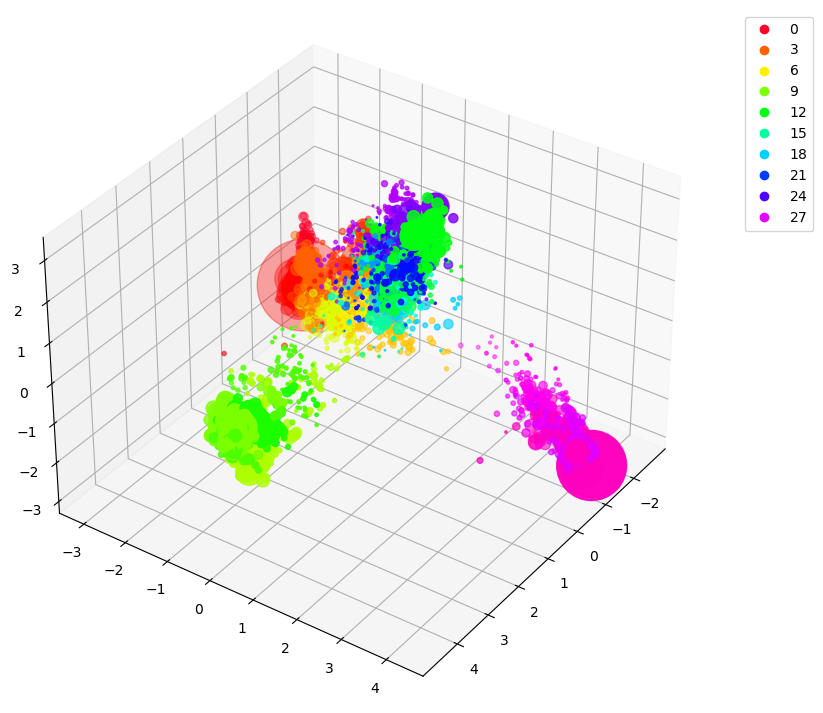

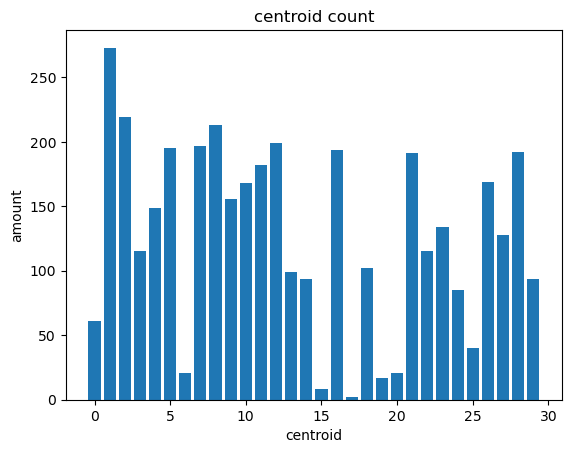

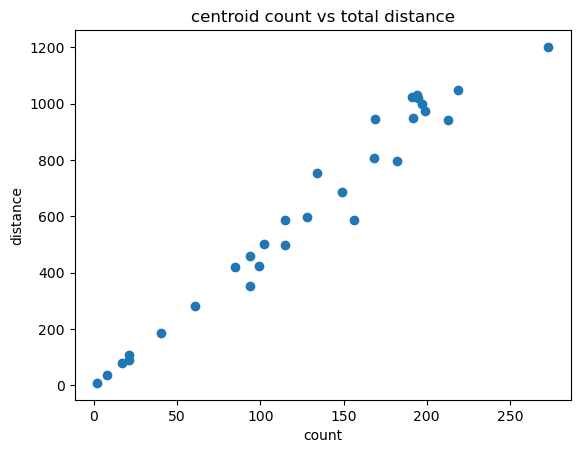

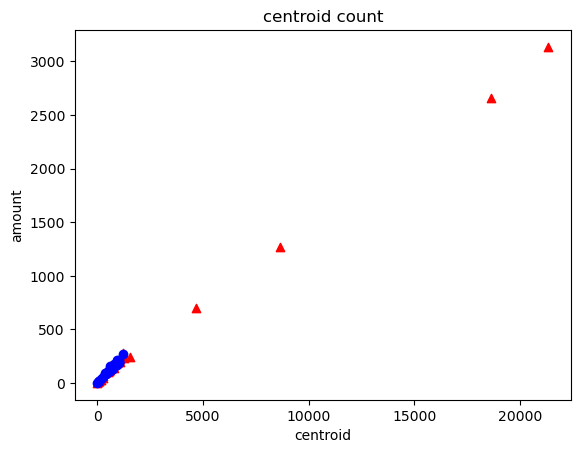

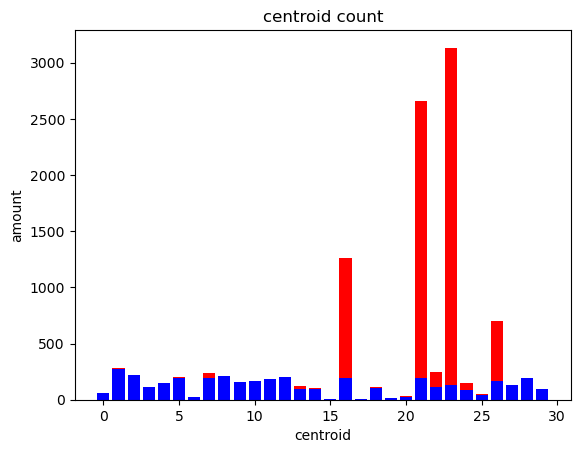

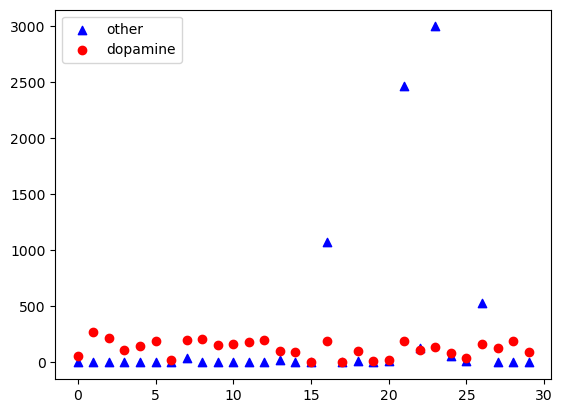

In [21]:
e1, e2, e3, e4 = perform_analysis(datas[0],30,dataoo,datas[1],dataoB)
show_labelc(e4,30,dataoB)

In [22]:
@interact(cid=(0,30))
def f1(cid=6):
    return findmcs(cid,e1,dataoo)
@interact(cid=(0,30))
def f2(cid=6):
    return findmcs(cid,e2,dataoB)
@interact(cid=(0,30),eid=(0,100))
def f3(cid=6,eid=0):
    return examine_cluster(e3,e1,cid,eid)
@interact(cid=(0,30),eid=(0,100))
def f3(cid=6,eid=0):
    return examine_cluster(e4,e2,cid,eid)

interactive(children=(IntSlider(value=6, description='cid', max=30), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=6, description='cid', max=30), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=6, description='cid', max=30), IntSlider(value=0, description='eid'), Ou…

interactive(children=(IntSlider(value=6, description='cid', max=30), IntSlider(value=0, description='eid'), Ou…

In [21]:
e1, _, e3, _ = perform_analysis(datas[1],250,dataoB,datas[1],dataoB)
show_labelc(e3,50,dataoB)

IndexError: list index out of range

In [22]:
@interact(cid=(0,50))
def f1(cid=6):
    return findmcs(cid,e1,dataoB)
@interact(cid=(0,50),eid=(0,100))
def f3(cid=6,eid=0):
    return examine_cluster(e3,e1,cid,eid)

interactive(children=(IntSlider(value=6, description='cid', max=50), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=6, description='cid', max=50), IntSlider(value=0, description='eid'), Ou…

70 / 220
4.627117795727534
thrombin


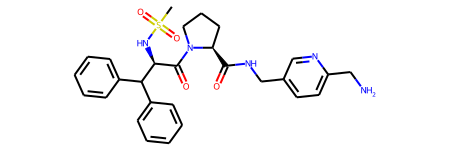

71 / 220
4.627715727406909
thrombin


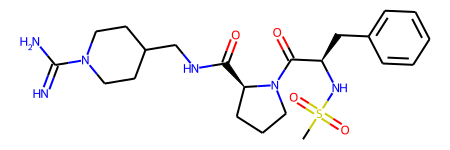

72 / 220
4.631004573988786
thrombin


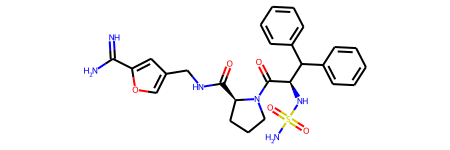

73 / 220
4.652462821967845
coagulation factor x


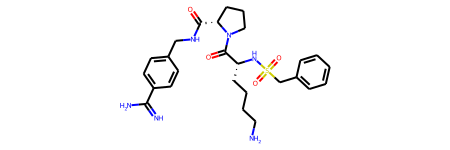

74 / 220
4.6571251831634255
thrombin


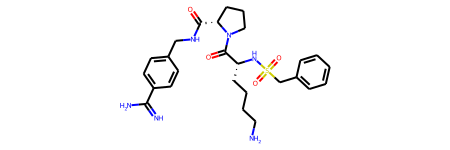

75 / 220
4.67595646228833
thrombin


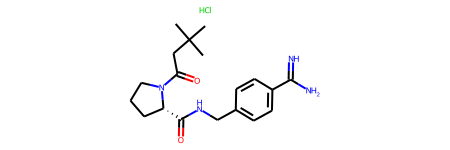

76 / 220
4.6812207020905365
thrombin


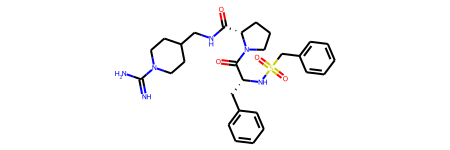

77 / 220
4.691024536999674
thrombin


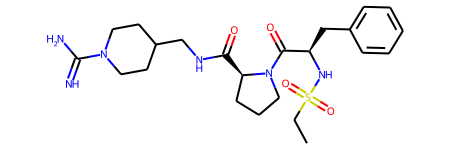

78 / 220
4.693471678386255
thrombin


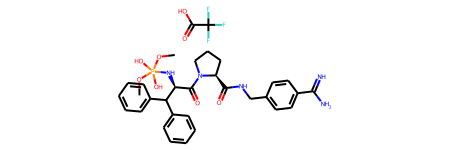

[04:31:11] UFFTYPER: Warning: hybridization set to SP3 for atom 2


79 / 220
4.694370293789588
thrombin


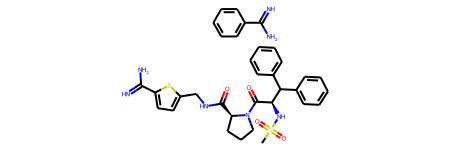

80 / 220
4.699107041482668
thrombin


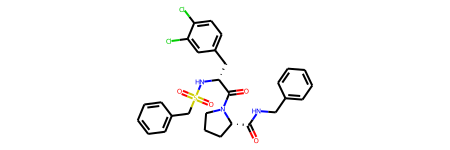

81 / 220
4.701417398014439
thrombin


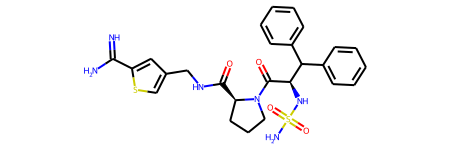

82 / 220
4.704401863938972
thrombin


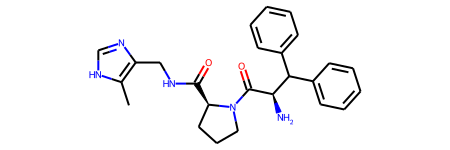

83 / 220
4.707906666713656
thrombin


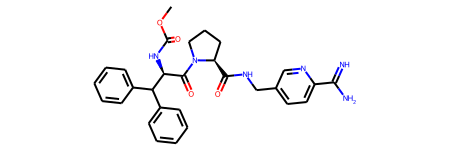

84 / 220
4.732560469193092
thrombin


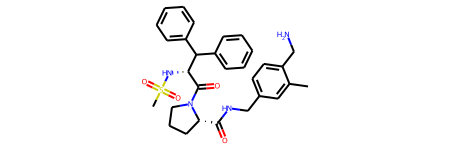

85 / 220
4.734291163682649
thrombin


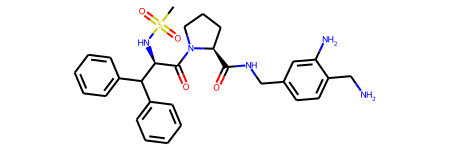

86 / 220
4.734863317671624
thrombin


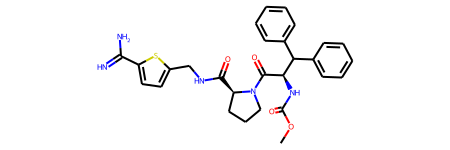

In [47]:
for i in range(70,87):
    examine_cluster(e3,e1,29,i)

In [6]:
dclserrm = []
dclserrd = []
dclserrmb = []
dclserrdb = []
for i in range(100,400,4):
    res = []
    resb = []
    print(i,end=",")
    for _ in range(5):
        cl = BisectingKMeans(n_clusters=i)
        clds = cl.fit_transform(datas[0])
        clid = cl.labels_m    
        res.append(silhouette_score(datas[0], cl.labels_))
        resb.append(np.sum(clds[np.arange(clds.shape[0]),clid]))
    dclserrm.append(np.mean(res))
    dclserrd.append(np.std(res))    
    dclserrmb.append(np.mean(resb))
    dclserrdb.append(np.std(resb))

100,104,108,112,116,120,124,128,132,136,140,144,148,152,156,160,164,168,172,176,180,184,188,192,196,200,204,208,212,216,220,224,228,232,236,240,244,248,252,256,260,264,268,272,276,280,284,288,292,296,300,304,308,312,316,320,324,328,332,336,340,344,348,352,356,360,364,368,372,376,380,384,388,392,396,

Text(0, 0.5, 'Score')

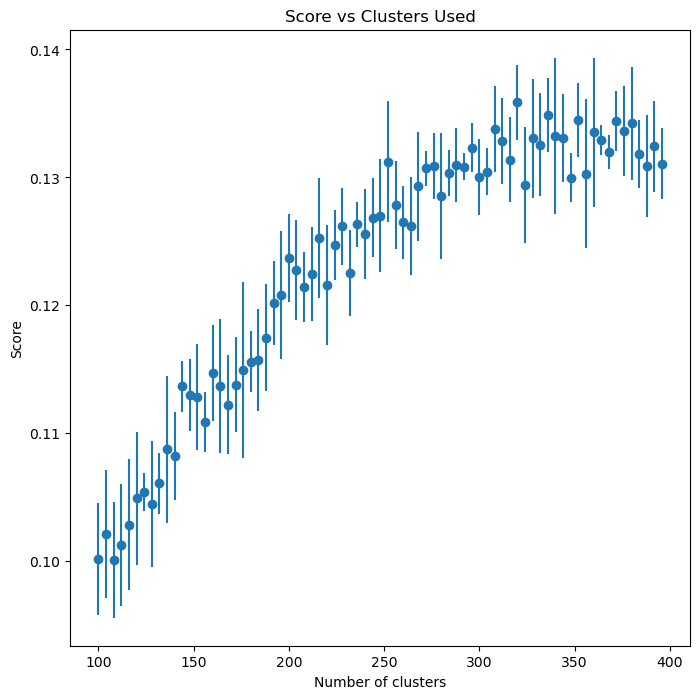

In [9]:
plt.figure(figsize=(8,8))
plt.errorbar(range(100,400,4), dclserrm,dclserrd,linestyle='None',fmt='o')
plt.title('Score vs Clusters Used')
plt.xlabel('Number of clusters')
plt.ylabel('Score')

Text(0, 0.5, 'Distance normalized')

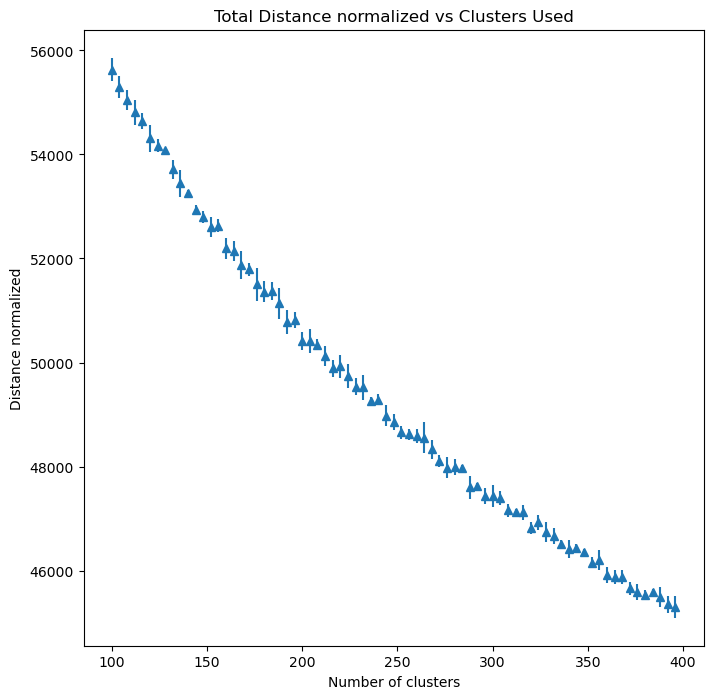

In [11]:
plt.figure(figsize=(8,8))
plt.errorbar(range(100,400,4),dclserrmb,dclserrdb,linestyle='None',fmt='^')
plt.title('Total Distance normalized vs Clusters Used')
plt.xlabel('Number of clusters')
plt.ylabel('Distance normalized')